# **Adding Advanced Features to the Training Loop**

Here we will cover some advanced techniques which are used during the pre-training, but also overlap with fine-tuning.

Specifically, we will cover:
- Warm-up
- Cosine Decay
- Gradient Clipping
- A modified training loop covering all three techniques.

## **Setup**

In [2]:
from importlib.metadata import version
import torch

print(f"Torch version: {version('torch')}")

Torch version: 2.7.0


In [3]:
from pathlib import Path
PROJECT_ROOT = Path().absolute().parent

In [4]:
from utils.components import GPTModel, create_dataloader_v1

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
model = GPTModel(GPT_CONFIG_124M)
model.eval(); # Dropout disabled during inference

In [5]:
data="data/the-verdict.txt" # Sticking with the tiny sample of the-verdict.
data_path = PROJECT_ROOT / data

with open(data_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [6]:
# Train - Validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))

torch.manual_seed(42)

train_loader = create_dataloader_v1(
    text_data[:split_idx],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    text_data[split_idx:],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

## **1. Learning Rate Warmup**

- Learning rate warmup can help stabilize training.
- During the step, the learning rate is gradually increased from a very low `initial_lr` value to a user-specified `peak_lr`.
- This allows the model to train with small weight updates, which mitigates the risk of large destabilizing updates during training.

In [7]:
n_epochs = 15
initial_lr = 0.0001
peak_lr = 0.01

In [8]:
# Number of warmup steps is between 0.1% to 20% of the total number of steps
total_steps = len(train_loader) * n_epochs
warmup_steps = int(0.2 * total_steps)
print(warmup_steps)

27


In [9]:
# Increment is difference between the peak_lr and initial_lr divided by the warmup steps
lr_increment = (peak_lr - initial_lr) / warmup_steps

global_step = -1
track_lrs = []

optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1
        
        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment
        else:
            lr = peak_lr
            
        # Apply calculated LR to the optimizer 
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])
        
        # Continue training loop's calculation of loss and weight updates...

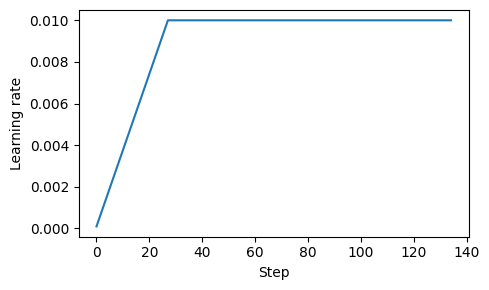

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.ylabel("Learning rate")
plt.xlabel("Step")
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs)
plt.tight_layout()
plt.show();

## **2. Cosine Decay / Annealing**

- Cosine decay is popular for training complex deep neural networks. It basically adjusts the learning rate across the training epochs.
- Here, the learning rate follows a cosine curve which decreases in value to approach near-zero following a half cosine cycle.
- The gradual reduction slows the pace of learning as the model begins to improve its weights; it also reduces the risk of over shooting the minima as the training progresses, thus allowing the weights to stabilize the training process for later stages.
- An alternative method to adjusting learning rates is to use linear decay as shown in the paper [OLMo: Accelerating the Science of Language Models](https://arxiv.org/abs/2402.00838))

In [11]:
import math

min_lr = 0.1 * initial_lr
track_lrs = []

lr_increment = (peak_lr - initial_lr) / warmup_steps
global_step = -1

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1
        
        # Adjust LR based on the current phase (warmup or cosine annealing)
        if global_step <  warmup_steps:
            # Use Linear warmup
            lr = initial_lr + global_step * lr_increment
        else:
            # Use Cosine Annealing after warmup
            progress = ((global_step - warmup_steps) / 
                        (total_training_steps - warmup_steps))
            lr = min_lr + (peak_lr - min_lr) * 0.5 * (
                1 + math.cos(math.pi * progress)
            )
        
        # Apply calculated LR to the optimizer
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])

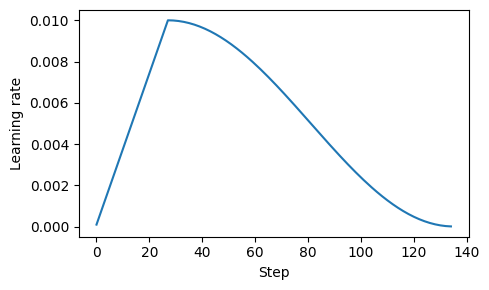

In [12]:
plt.figure(figsize=(5, 3))
plt.ylabel("Learning rate")
plt.xlabel("Step")
plt.plot(range(total_training_steps), track_lrs)
plt.tight_layout();
plt.show()

## **3. Gradient Clipping**

- Gradient clipping ensures stabilized training by scaling down any gradients which exceed a predetermined threshold limit during back-propagation.
- In the code sample below, using `max_norm=1.0` in PyTorch's `clip_grad_norm_` method means that the norm of the gradients is clipped to a value which does not exceed 1.0.
- Here the norm refers to the L2 or Euclidean norm when measured according to the gradient vector's length / magnitude in the model's parameter space.

In [13]:
from utils.components import calc_loss_batch

# Initialize a new model and calculate the loss for a training batch
torch.manual_seed(42)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

loss = calc_loss_batch(input_batch, target_batch, model, device)
loss.backward()

In [15]:
# Utility funciton to calculate the highest gradient based on all model weights
def find_highest_gradient(model):
    max_grad = None
    for param in model.parameters():
        if param.grad is not None: # stored gradients
            grad_values = param.grad.data.flatten()
            max_grad_param = grad_values.max()
            if max_grad is None or max_grad_param > max_grad:
                max_grad = max_grad_param
    return max_grad

print(find_highest_gradient(model))

tensor(0.0313, device='cuda:0')


In [16]:
# Applying gradient clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
print(find_highest_gradient(model))

tensor(0.0313, device='cuda:0')


## **4. Modified Training Loop**

This updated training loop will now include LR Warmup, Cosine Annealing and Gradient Clipping. Moving forward, `train_model_simple` will be replaced by the new and improved `train_model`.

In [17]:
from utils.components import evaluate_model, generate_and_print_sample

def train_model(model, train_loader, val_loader, optimizer, device, n_epochs,
                eval_freq, eval_iter, start_context, tokenizer, warmup_steps,
                initial_lr=3e-5, min_lr=1e-6):
    
    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    tokens_seen, global_step = 0, -1
    
    # Retrieve the maximum LR from the optimizer
    peak_lr = optimizer.param_groups[0]["lr"]
    
    # Calculate the total number of iterations in the training process
    total_training_steps = len(train_loader) * n_epochs
    
    # Calculate the learning rate increment during the warmup phase
    lr_increment = (peak_lr - initial_lr) / warmup_steps
    
    for epoch in range(n_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            global_step += 1
            
            # Adjust the LR based on the current phase i.e. warmup or cosine annealing
            if global_step < warmup_steps:
                #Linear warmup
                lr = initial_lr + global_step * lr_increment
            else:
                # Cosing annealing after warmup
                progress = ((global_step - warmup_steps) / 
                            (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
                
            # Apply the calculated LR to the optimizer
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr) # Store current LR
            
            # Calculate backprop loss
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            
            # Apply gradient clipping. Using >= avoids a skipped clipping step after warmup
            if global_step >= warmup_steps:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
            optimizer.step()
            tokens_seen += input_batch.numel()
            
            # Periodically evaluate the model on the training and validation sets
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader,
                    device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                # Print current losses
                print(f"Epoch {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )
        
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    
    return train_losses, val_losses, track_tokens_seen, track_lrs
                

In [19]:
import tiktoken

import time
start_time = time.time()

torch.manual_seed(42)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

peak_lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=peak_lr, weight_decay=0.1)
tokenizer = tiktoken.get_encoding("gpt2")

n_epochs = 30

train_losses, val_losses, tokens_seen, lrs = train_model(
    model, train_loader, val_loader, optimizer, device, n_epochs=n_epochs,
    eval_freq=5, eval_iter=1, start_context="Time and tide wait",
    tokenizer=tokenizer, warmup_steps=warmup_steps, 
    initial_lr=1e-5, min_lr=1e-5
)

end_time = time.time()
exec_time = (end_time - start_time) / 60
print(f"Training completed in {exec_time:.2f} minutes.")

Epoch 1 (Iter 000000): Train loss 10.983, Val loss 11.008
Epoch 1 (Iter 000005): Train loss 9.149, Val loss 9.494
Time and tide wait, the,,, the,,,,,, the,, the,, the,, the,,, the,,,,,,,, the,, the,,,,,, the,,, the,
Epoch 2 (Iter 000010): Train loss 8.095, Val loss 8.237
Epoch 2 (Iter 000015): Train loss 6.383, Val loss 6.888
Time and tide wait,,,,,,,,,,,, the,,,,,, the,,,,, the                        
Epoch 3 (Iter 000020): Train loss 5.982, Val loss 6.659
Epoch 3 (Iter 000025): Train loss 6.140, Val loss 6.832
Time and tide wait his I I I-- I I I--I--I I I I I I I-- I I I I I I I I I I I I I I--I--I I I I I--I--I I--I I I
Epoch 4 (Iter 000030): Train loss 5.940, Val loss 7.083
Epoch 4 (Iter 000035): Train loss 5.936, Val loss 7.025
Time and tide wait.                                                 
Epoch 5 (Iter 000040): Train loss 5.811, Val loss 6.897
Time and tide wait the                                                 
Epoch 6 (Iter 000045): Train loss 5.823, Val loss 6.786
Epo

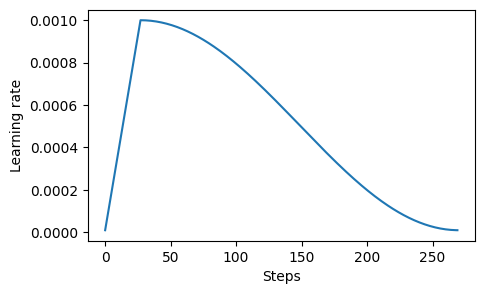

In [ ]:
# Checking the LR
plt.figure(figsize=(5, 3))
plt.plot(range(len(lrs)), lrs)
plt.ylabel("Learning rate")
plt.xlabel("Steps")
plt.show()

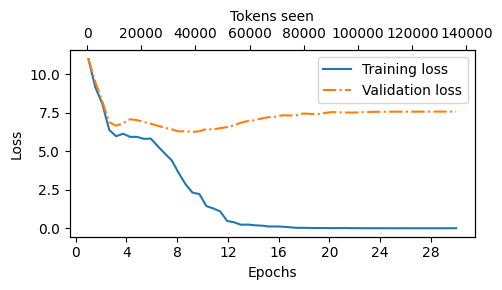

<Figure size 640x480 with 0 Axes>

In [22]:
from utils.components import plot_losses

# Checking loss curves
epochs_tensor = torch.linspace(1, n_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
plt.tight_layout()
plt.show()